In [138]:
import pandas as pd
from collections import Counter, defaultdict
import math
import numpy as np
import plotly.express as px
import seaborn as sns
from scipy.stats import norm

# 1. EDA

In [88]:
signal=pd.read_csv('ecg.csv')
annotation=pd.read_csv('ecg_pattern.csv')
del annotation["Unnamed: 0"]
display(signal)
display(annotation)

,'sample #','MLII','V1','V2','V4','V5',Name
0,0,995.0,NaN,NaN,NaN,1011.0,100
1,1,995.0,NaN,NaN,NaN,1011.0,100
2,2,995.0,NaN,NaN,NaN,1011.0,100
3,3,995.0,NaN,NaN,NaN,1011.0,100
4,4,995.0,NaN,NaN,NaN,1011.0,100
...,...,...,...,...,...,...,...
31199995,649995,946.0,1038.0,NaN,NaN,NaN,234
31199996,649996,946.0,1038.0,NaN,NaN,NaN,234
31199997,649997,945.0,1039.0,NaN,NaN,NaN,234
31199998,649998,948.0,1040.0,NaN,NaN,NaN,234


,Time,Sample,Type,Sub,Chan,Num,Aux,Name
0,0:00.050,18,+,0,0,0,(N,100
1,0:00.214,77,N,0,0,0,NaN,100
2,0:01.028,370,N,0,0,0,NaN,100
3,0:01.839,662,N,0,0,0,NaN,100
4,0:02.628,946,N,0,0,0,NaN,100
...,...,...,...,...,...,...,...,...
112642,30:02.214,648797,N,0,0,0,NaN,234
112643,30:02.889,649040,N,0,0,0,NaN,234
112644,30:03.589,649292,N,0,0,0,NaN,234
112645,30:04.267,649536,N,0,0,0,NaN,234


## 1-1) 리듬별 빈도수 확인

In [89]:
from collections import Counter
display(Counter(annotation["Aux"]))

target = ["(B", "(N", "(SVTA", "(VT"]
count = Counter( annotation["Aux"][ annotation["Aux"].isin(target) ] )
display(count)

Counter({'(N': 530,
         nan: 110919,
         '(P': 60,
         '(B': 221,
         '(VT': 61,
         '(T': 83,
         '(SVTA': 26,
         '(NOD': 36,
         '(IVR': 4,
         '(AFIB': 107,
         '(AFL': 45,
         '(VFL': 6,
         'TS': 6,
         'PSE': 3,
         'MISSB': 428,
         '(AB': 3,
         '(PREX': 103,
         '(BII': 5,
         '(SBR': 1})

Counter({'(N': 530, '(B': 221, '(VT': 61, '(SVTA': 26})

## 1-2) 환자별 타겟 리듬 관측도수, 비율 

In [90]:
name = signal["Name"].unique()
rhythm_by_person = pd.DataFrame(name,columns=['Name'])
#display(rhythm_by_person)

for i, n in enumerate(name):
    temp = annotation[annotation["Name"]==n]
    temp_count = Counter(temp["Aux"][ temp["Aux"].isin(target) ])

    rhythm_by_person.loc[i,"(N"] = int(temp_count["(N"])
    rhythm_by_person.loc[i,"(B"] = int(temp_count["(B"])
    rhythm_by_person.loc[i,"(SVTA"] = int(temp_count["(SVTA"])
    rhythm_by_person.loc[i,"(VT"] = int(temp_count["(VT"])
    
    total=int(temp_count["(N"]+temp_count["(B"]+temp_count["(SVTA"]+temp_count["(VT"])
    if total!=0:
        rhythm_by_person.loc[i,"(N rate"] = round(int(temp_count["(N"])/total,2)
        rhythm_by_person.loc[i,"(B rate"] = round(int(temp_count["(B"])/total,2)
        rhythm_by_person.loc[i,"(SVTA rate"] = round(int(temp_count["(SVTA"])/total,2)
        rhythm_by_person.loc[i,"(VT rate"] = round(int(temp_count["(VT"])/total,2)
rhythm_by_person

,Name,(N,(B,(SVTA,(VT,(N rate,(B rate,(SVTA rate,(VT rate
0,100,1.0,0.0,0.0,0.0,1.00,0.00,0.00,0.00
1,101,1.0,0.0,0.0,0.0,1.00,0.00,0.00,0.00
2,102,2.0,0.0,0.0,0.0,1.00,0.00,0.00,0.00
3,103,1.0,0.0,0.0,0.0,1.00,0.00,0.00,0.00
4,104,22.0,0.0,0.0,0.0,1.00,0.00,0.00,0.00
5,105,1.0,0.0,0.0,0.0,1.00,0.00,0.00,0.00
6,106,21.0,18.0,0.0,1.0,0.53,0.45,0.00,0.03
7,107,0.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN
8,108,1.0,0.0,0.0,0.0,1.00,0.00,0.00,0.00
9,109,1.0,0.0,0.0,0.0,1.00,0.00,0.00,0.00


# 1-3) 각 환자에서 발생하는  타겟 리듬의 최대 빈도수/비율

In [91]:
rhythm_by_person.iloc[:,1:].max()

(N            104.00
(B             71.00
(SVTA          10.00
(VT            21.00
(N rate         1.00
(B rate         0.90
(SVTA rate      0.48
(VT rate        1.00
dtype: float64

## 1-4) 각 타겟별 signal 수 확인

In [92]:
seIdx = []    # [count, strt_sample_Idx, end_sample_Idx, Name, rhythm_type]
idx = 0
for n in name:
    annotation_temp = annotation[annotation["Name"]==n]
    s=0
    for i, r in enumerate(annotation_temp["Aux"]):
        if(pd.isnull(r)==False):
            if(s!=0):
                n = annotation_temp["Name"].iloc[i]
                if(i==len(annotation_temp)-1):
                    e = max(signal["'sample #'"][signal["Name"]==n])
                else:
                    e = annotation_temp["Sample"].iloc[i-1]
                seIdx.append([(e-s)+1, s, e, n, t])
                s = 0
            if(r in target):
                t = annotation_temp["Aux"].iloc[i]
                s = annotation_temp["Sample"].iloc[i]
        else:
            if(s!=0):
                if(i==len(annotation_temp)-1):
                    n = annotation_temp["Name"].iloc[i]
                    e = max(signal[signal["Name"]==n]["'sample #'"])
                    seIdx.append([(e-s)+1, s, e, n, t])
            
seldx_pd=pd.DataFrame(seIdx, columns=['count', 'strt_sample_Idx', 'end_sample_Idx', 'Name', 'rhythm_type'])
seldx_pd

,count,strt_sample_Idx,end_sample_Idx,Name,rhythm_type
0,649982,18,649999,100,(N
1,649993,7,649999,101,(N
2,4926,29133,34058,102,(N
3,24144,38682,62825,102,(N
4,649979,21,649999,103,(N
...,...,...,...,...,...
832,1763,644479,646241,233,(B
833,3627,646373,649999,233,(N
834,304261,52,304312,234,(N
835,9093,304425,313517,234,(SVTA


## 1-5) 타겟 리듬별 크기 확인

In [94]:
from tqdm.notebook import tqdm

N = []
B = []
SVTA = []
VT = []
ecg_lst = []
name = signal["Name"].unique()
for nn in tqdm(name, desc='name'):
    ecg_temp = signal[signal["Name"]==nn]
    for c, s, e, n, t in tqdm(seIdx, desc='seIdx'):
        if(n!=nn): continue
        si = list(ecg_temp[ecg_temp["'sample #'"]==s].index)[0]
        ei = list(ecg_temp[ecg_temp["'sample #'"]==e].index)[0]
        if(n==102 | n==104):
            ecg_lst = list(ecg_temp["'V5'"].iloc[si:ei+1])
        else:
            ecg_lst = list(ecg_temp["'MLII'"].loc[si:ei+1])
        if(t=="(N"):
            N.append(ecg_lst)
        elif(t=="(B"):
            B.append(ecg_lst)
        elif(t=="(SVTA"):
            SVTA.append(ecg_lst)
        else:
            VT.append(ecg_lst)
            
N = pd.Series(N)
B = pd.Series(B)
SVTA = pd.Series(SVTA)
VT = pd.Series(VT)

In [95]:
rhythmLens_N = []
rhythmLens_B = []
rhythmLens_SVTA = []
rhythmLens_VT = []

for r in N:
    rhythmLens_N.append(len(r))
for r in B:
    rhythmLens_B.append(len(r))
for r in SVTA:
    rhythmLens_SVTA.append(len(r))
for r in VT:
    rhythmLens_VT.append(len(r))

### (1) N

Basic Statistics of (N
Num :  529
Mean :  42094.2381852552
Var :  14982242347.463116
Std :  122401.97035776473
Max :  649993
Min :  37
Median :  4208.0
25 Percentile :  1337.0
75 Percentile :  20812.0


Text(0.5, 1.0, 'Dist. of (N')

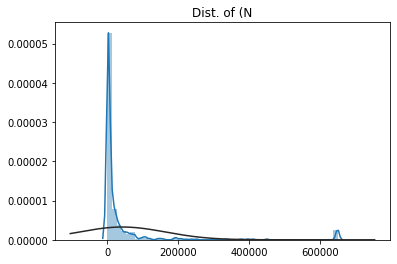

In [111]:
print("Basic Statistics of (N")
print("Num : ", len(rhythmLens_N))
print("Mean : ", np.mean(rhythmLens_N))
print("Var : ", np.var(rhythmLens_N))
print("Std : ", np.std(rhythmLens_N))
print("Max : " , np.max(rhythmLens_N))
print("Min : ", np.min(rhythmLens_N))
print("Median : ", np.median(rhythmLens_N))
print("25 Percentile : ", np.percentile(rhythmLens_N, 25))
print("75 Percentile : ", np.percentile(rhythmLens_N, 75))


fig = px.bar(x=range(len(rhythmLens_N)), y=sorted(rhythmLens_N))
fig.update_layout(title="Each sorted length of (N Rhythms",
                 yaxis_title="Length",)
fig.show()

sns.distplot(rhythmLens_N, fit=norm).set_title('Dist. of (N')

#Log 변환
#sns.distplot(np.log(rhythmLens_N), fit=norm).set_title('Dist. of Log("(N")')

### (2) B

Basic Statistics of (B
Num :  221
Mean :  3924.176470588235
Var :  52799745.367048174
Std :  7266.34332845952
Max :  53959
Min :  859
Median :  1480.0
25 Percentile :  1233.0
75 Percentile :  2794.0


Text(0.5, 1.0, 'Dist. of (B')

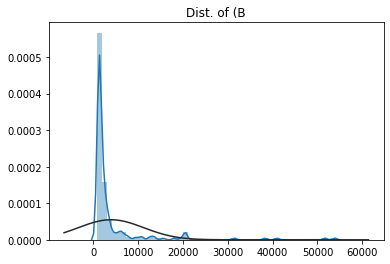

In [114]:
print("Basic Statistics of (B")
print("Num : ", len(rhythmLens_B))
print("Mean : ", np.mean(rhythmLens_B))
print("Var : ", np.var(rhythmLens_B))
print("Std : ", np.std(rhythmLens_B))
print("Max : " , np.max(rhythmLens_B))
print("Min : ", np.min(rhythmLens_B))
print("Median : ", np.median(rhythmLens_B))
print("25 Percentile : ", np.percentile(rhythmLens_B, 25))
print("75 Percentile : ", np.percentile(rhythmLens_B, 75))

fig = px.bar(x=range(len(rhythmLens_B)), y=rhythmLens_B)
fig.update_layout(title="Each length of (B Rhythms",
                 yaxis_title="Length",)
fig.show()

sns.distplot(rhythmLens_B, fit=norm).set_title('Dist. of (B')

### (3) SVTA

Basic Statistics of (SVTA
Num :  26
Mean :  2730.8076923076924
Var :  17846806.693786982
Std :  4224.548105275519
Max :  18639
Min :  353
Median :  671.5
25 Percentile :  482.25
75 Percentile :  2370.75


Text(0.5, 1.0, 'Dist. of (SVTA')

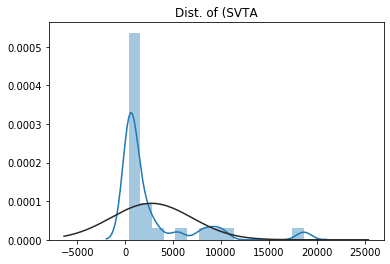

In [115]:
print("Basic Statistics of (SVTA")
print("Num : ", len(rhythmLens_SVTA))
print("Mean : ", np.mean(rhythmLens_SVTA))
print("Var : ", np.var(rhythmLens_SVTA))
print("Std : ", np.std(rhythmLens_SVTA))
print("Max : " , np.max(rhythmLens_SVTA))
print("Min : ", np.min(rhythmLens_SVTA))
print("Median : ", np.median(rhythmLens_SVTA))
print("25 Percentile : ", np.percentile(rhythmLens_SVTA, 25))
print("75 Percentile : ", np.percentile(rhythmLens_SVTA, 75))

fig = px.bar(x=range(len(rhythmLens_SVTA)), y=rhythmLens_SVTA)
fig.update_layout(title="Each length of (SVTA Rhythms",
                 yaxis_title="Length",)
fig.show()

sns.distplot(rhythmLens_SVTA, fit=norm).set_title('Dist. of (SVTA')

### (4) VT

Basic Statistics of (VT
Num :  61
Mean :  1076.2295081967213
Var :  8820634.340768611
Std :  2969.95527588693
Max :  19745
Min :  275
Median :  419.0
25 Percentile :  374.0
75 Percentile :  588.0


Text(0.5, 1.0, 'Dist. of (VT')

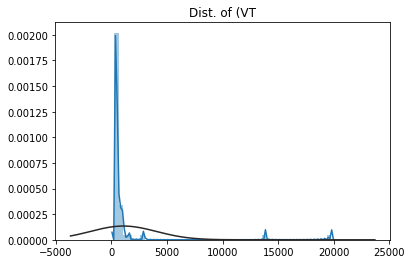

In [116]:
print("Basic Statistics of (VT")
print("Num : ", len(rhythmLens_VT))
print("Mean : ", np.mean(rhythmLens_VT))
print("Var : ", np.var(rhythmLens_VT))
print("Std : ", np.std(rhythmLens_VT))
print("Max : " , np.max(rhythmLens_VT))
print("Min : ", np.min(rhythmLens_VT))
print("Median : ", np.median(rhythmLens_VT))
print("25 Percentile : ", np.percentile(rhythmLens_VT, 25))
print("75 Percentile : ", np.percentile(rhythmLens_VT, 75))

fig = px.bar(x=range(len(rhythmLens_VT)), y=rhythmLens_VT)
fig.update_layout(title="Each length of (VT Rhythms",
                 yaxis_title="Length",)
fig.show()

sns.distplot(rhythmLens_VT, fit=norm).set_title('Dist. of (VT')

# 2. 리듬별 비트 타입 정보 추가

In [121]:
annotation_temp = annotation[annotation["Name"]==100]
annotation_temp

,Time,Sample,Type,Sub,Chan,Num,Aux,Name
0,0:00.050,18,+,0,0,0,(N,100
1,0:00.214,77,N,0,0,0,NaN,100
2,0:01.028,370,N,0,0,0,NaN,100
3,0:01.839,662,N,0,0,0,NaN,100
4,0:02.628,946,N,0,0,0,NaN,100
...,...,...,...,...,...,...,...,...
2269,30:02.717,648978,N,0,0,0,NaN,100
2270,30:03.422,649232,N,0,0,0,NaN,100
2271,30:04.122,649484,N,0,0,0,NaN,100
2272,30:04.817,649734,N,0,0,0,NaN,100


In [154]:
seIdx = []    # [count, strt_sample_Idx, end_sample_Idx, Name, rhythm_type]
beat_lst=[]
idx = 0
for n in name:
    annotation_temp = annotation[annotation["Name"]==n]
    s=0
    beat=defaultdict(int)
    for i, r in enumerate(annotation_temp["Aux"]):
        beat[annotation_temp.iloc[i,2]]+=1
        if(pd.isnull(r)==False):
            if(s!=0):
                n = annotation_temp["Name"].iloc[i]
                if(i==len(annotation_temp)-1):
                    e = max(signal["'sample #'"][signal["Name"]==n])
                else:
                    e = annotation_temp["Sample"].iloc[i-1]
                seIdx.append([(e-s)+1, s, e, n, t])
                s = 0
                beat_lst.append(list(beat.items()))
                beat=defaultdict(int)
            if(r in target):
                t = annotation_temp["Aux"].iloc[i]
                s = annotation_temp["Sample"].iloc[i]
        else:
            if(s!=0):
                if(i==len(annotation_temp)-1):
                    n = annotation_temp["Name"].iloc[i]
                    e = max(signal[signal["Name"]==n]["'sample #'"])
                    seIdx.append([(e-s)+1, s, e, n, t])
                    beat_lst.append(list(beat.items()))
                    beat=defaultdict(int)
seldx_pd=pd.DataFrame(seIdx, columns=['count', 'strt_sample_Idx', 'end_sample_Idx', 'Name', 'rhythm_type'])
seldx_pd

,count,strt_sample_Idx,end_sample_Idx,Name,rhythm_type
0,649982,18,649999,100,(N
1,649993,7,649999,101,(N
2,4926,29133,34058,102,(N
3,24144,38682,62825,102,(N
4,649979,21,649999,103,(N
...,...,...,...,...,...
832,1763,644479,646241,233,(B
833,3627,646373,649999,233,(N
834,304261,52,304312,234,(N
835,9093,304425,313517,234,(SVTA


In [144]:
beat_lst
beat_type_cols=set()
for item in beat_lst:
    for jtem in item:
        beat_type_cols.add(jtem)
print(list(beat_type_cols))
'''
beat_type_pd=pd.DataFrame(columns=beat_type_cols)
for i,row in enumerate(beat_lst):
    tmp_row=[0]*len(beat_type_cols)
    for j,value in enumerate(beat_type_cols):
        if value in row:
            tmp_row[j]=1
    beat_type_pd.loc[i]=tmp_row

pd.concat([seldx_pd, beat_type_pd],axis=1)
'''

'\nbeat_type_pd=pd.DataFrame(columns=beat_type_cols)\nfor i,row in enumerate(beat_lst):\n    tmp_row=[0]*len(beat_type_cols)\n    for j,value in enumerate(beat_type_cols):\n        if value in row:\n            tmp_row[j]=1\n    beat_type_pd.loc[i]=tmp_row\n\npd.concat([seldx_pd, beat_type_pd],axis=1)\n'

In [160]:
beat_type_cols=set()
for item in beat_lst:
    for jtem in item:
        beat_type_cols.add(jtem[0])
beat_type_cols=list(beat_type_cols)
beat_type_cols.append('total_beat')
beat_type_pd=pd.DataFrame(columns=list(beat_type_cols))
for i, row in enumerate(beat_lst):
    tmp_row=[0]*len(beat_type_cols)
    type_cnt=len(row)
    for j in range(type_cnt):
        if row[j][0] in beat_type_cols:
            tmp_row[beat_type_cols.index(row[j][0])] = row[j][1]
            tmp_row[-1] += row[j][1]
    beat_type_pd.loc[i] = tmp_row
    
data = pd.concat([seldx_pd, beat_type_pd],axis=1)
data

,count,strt_sample_Idx,end_sample_Idx,Name,rhythm_type,/,Q,R,e,L,...,x,],j,A,~,"""",J,N,!,total_beat
0,649982,18,649999,100,(N,0,0,0,0,0,...,0,0,0,33,0,0,0,2239,0,2274
1,649993,7,649999,101,(N,0,2,0,0,0,...,0,0,0,3,4,0,0,1860,0,1874
2,4926,29133,34058,102,(N,92,0,0,0,0,...,0,0,0,0,0,0,0,17,0,119
3,24144,38682,62825,102,(N,6,0,0,0,0,...,0,0,0,0,0,0,0,81,0,101
4,649979,21,649999,103,(N,0,0,0,0,0,...,0,0,0,2,6,0,0,2082,0,2091
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
832,1763,644479,646241,233,(B,0,0,0,0,0,...,0,0,0,0,0,0,0,4,0,10
833,3627,646373,649999,233,(N,0,0,0,0,0,...,0,0,0,0,0,0,0,14,0,17
834,304261,52,304312,234,(N,0,0,0,0,0,...,0,0,0,0,4,0,0,1297,0,1303
835,9093,304425,313517,234,(SVTA,0,0,0,0,0,...,0,0,0,0,0,0,50,0,0,51


# 3. 차원축소
## 3-1. PCA: 결과 좋지 않음.
## 3-2. PCA 기반으로 t-SNE: 결과 좋지 않음.

### 전처리 필요할 것으로 보임.

In [244]:
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
x = data.drop(['rhythm_type'], axis=1).values # 독립변인들의 value값만 추출
y = data['rhythm_type'].values # 종속변인 추출

x = StandardScaler().fit_transform(x) # x객체에 x를 표준화한 데이터를 저장
features=list(data.columns)
features.remove('rhythm_type')
pd.DataFrame(x, columns=features)

pca=PCA(n_components=len(features)-1)
pca_fit=pca.fit(x)
print('Explain Variance Ratio : \n', np.round_(pca.explained_variance_ratio_,2))

print('\n\nSingular value: \n', pca.singular_values_)
print('\n\nSingular vector: \n', pca.components_.T)
print('\n\nExplain Standard Deviation: \n', np.round_(np.sqrt(pca.explained_variance_)))
print('\n\nNoise Variance: \n', pca.noise_variance_)

Explain Variance Ratio : 
 [0.14 0.09 0.08 0.07 0.06 0.06 0.05 0.04 0.04 0.04 0.04 0.04 0.04 0.04
 0.03 0.03 0.03 0.02 0.02 0.02 0.01 0.01 0.01 0.   0.   0.   0.  ]


Singular value: 
 [5.72308047e+01 4.49139232e+01 4.26378970e+01 4.05499449e+01
 3.67684265e+01 3.60281430e+01 3.45026957e+01 3.18644137e+01
 3.17203610e+01 3.07649157e+01 2.97612795e+01 2.91886063e+01
 2.88890377e+01 2.87327584e+01 2.81155452e+01 2.65705783e+01
 2.51636821e+01 2.39141222e+01 2.32582261e+01 2.05885015e+01
 1.74974004e+01 1.70881714e+01 1.14571249e+01 6.32818519e+00
 6.06616531e+00 1.47158339e+00 1.28483787e-14]


Singular vector: 
 [[ 4.57795701e-01  1.47050385e-05 -6.88036525e-02 -3.81372383e-02
   1.71207503e-01  3.79301687e-03 -1.90591206e-01 -1.40585917e-02
  -4.32938728e-02 -1.02062590e-01  7.49628207e-03 -3.06731327e-02
   4.44933774e-03  2.76219557e-02 -7.90275867e-02 -1.62638626e-02
  -6.22693421e-03  1.44154845e-01 -1.95304971e-02 -8.30502638e-02
   2.23154855e-02 -2.64494621e-02  1.00973845e-01 -

   1.56338637e-01 -1.22505852e-02 -7.17719867e-01]]


Explain Standard Deviation: 
 [2. 2. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 0. 0.
 0. 0. 0.]


Noise Variance: 
 1.544615785372051e-32


In [247]:
cumsum = np.cumsum(pca.explained_variance_ratio_) #분산의 설명량을 누적합
num_d = np.argmax(cumsum >= 0.80) + 1 # 분산의 설명량이 95%이상 되는 차원의 수
display(num_d)
pca = PCA(n_components=0.80) #95%이상의 분산을 설명력을 갖는 차원축소
new_pca_fit = pca.fit_transform(x)
new_pca_fit_pd= pd.DataFrame(new_pca_fit_pd)

14

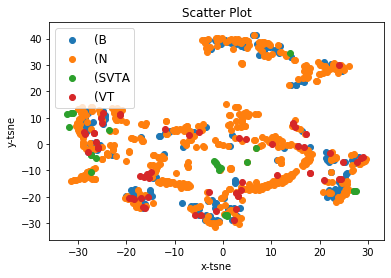

In [248]:
# Perform the necessary imports
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE
#from plotnine import *

tsne = TSNE(n_components=2)
tsne_results = tsne.fit_transform(new_pca_fit)

df_tsne = pd.concat([new_pca_fit_pd,data['rhythm_type']],axis=1)
df_tsne['x_tsne'] = tsne_results[:,0]
df_tsne['y_tsne'] = tsne_results[:,1]

groups= df_tsne.groupby('rhythm_type')
fig, ax = plt.subplots()
for rhythm, group in groups:
    ax.scatter(group.x_tsne, group.y_tsne, label=rhythm)
    
ax.legend(fontsize=12, loc='upper left') # legend position

plt.title('Scatter Plot')
plt.xlabel('x-tsne')
plt.ylabel('y-tsne')
plt.show()

In [ ]:
def network(x_train,y_train,x_test,y_test):
    im_shape=(x_train.shape[1],1)
    inputs_cnn=Input(shape=(im_shape),name='inputs_cnn')
    
    #conv. layer 1
    conv1_1=Convolution1D(64,(3),activation="relu",input_shape=im_shape)(inputs_cnn)
    conv1_2=BatchNormalization()(conv1_1)
    #conv. layer 2
    conv2_1=Convolution1D(64,(3),activation="relu",input_shape=im_shape)(conv1_1)
    conv2_2=BatchNormalization()(conv2_1)
    
    #pooling layer 1
    pool1=MaxPool1D(pool_size=(2),strides=(2),padding="same")(conv2_2)
    
    #conv. layer 3
    conv3_1=Convolution1D(128,(3),activation="relu",input_shape=im_shape)(pool1)
    conv3_2=BatchNormalization()(conv3_1)
    #conv. layer 4
    conv4_1=Convolution1D(128,(3),activation="relu",input_shape=im_shape)(conv3_2)
    conv4_2=BatchNormalization()(conv4_1)
    
    #pooling layer 2
    pool2=MaxPool1D(pool_size=(2),strides=(2),padding="same")(conv4_2)
    
    #conv. layer 5
    conv5_1=Convolution1D(256,(3),activation="elu",input_shape=im_shape)(pool2)
    conv5_2=BatchNormalization()(conv5_1)
    #conv. layer 6
    conv6_1=Convolution1D(256,(3),activation="elu",input_shape=im_shape)(conv5_2)
    conv6_2=BatchNormalization()(conv6_1)
    #conv. layer 7
    conv7_1=Convolution1D(256,(3),activation="elu",input_shape=im_shape)(conv6_2)
    conv7_2=BatchNormalization()(conv7_1)
    
    #pooling layer 3
    pool3=MaxPool1D(pool_size=(2),strides=(2),padding="same")(conv7_2)
    
    
    #conv. layer 8
    conv8_1=Convolution1D(256,(3),activation="elu",input_shape=im_shape)(pool3)
    conv8_2=BatchNormalization()(conv8_1)
    #conv. layer 9
    conv9_1=Convolution1D(256,(3),activation="elu",input_shape=im_shape)(conv8_2)
    conv9_2=BatchNormalization()(conv9_1)
    #conv. layer 10
    conv10_1=Convolution1D(256,(3),activation="elu",input_shape=im_shape)(conv9_2)
    conv10_2=BatchNormalization()(conv10_1)
    
    #pooling layer 4
    pool4=MaxPool1D(pool_size=(2),strides=(2),padding="same")(conv10_2)
    
    #conv. layer 11
    conv11_1=Convolution1D(512,(3),activation="relu",input_shape=im_shape)(pool4)
    conv11_2=BatchNormalization()(conv11_1)
    #conv. layer 12
    conv12_1=Convolution1D(512,(3),activation="relu",input_shape=im_shape)(conv11_2)
    conv12_2=BatchNormalization()(conv12_1)
    #conv. layer 13
    conv13_1=Convolution1D(512,(3),activation="relu",input_shape=im_shape)(conv12_2)
    conv13_2=BatchNormalization()(conv13_1)
    
    #pooling layer 5
    pool5=MaxPool1D(pool_size=(2),strides=(2),padding="same")(conv13_2)
    
    #flattened layer 1
    flatten=Flatten()(pool3)
    #dense layers
    # Dense(1000)의 의미는 1000개의 hidden unit을 가지는 fully connected layer
    dense_end1=Dense(1000,activation='relu')(flatten)
    dense_end2=Dense(1000,activation='relu')(dense_end1)
    #output layers
    main_output=Dense(6,activation='softmax',name='main_output')(dense_end1)
    
    model=Model(inputs=inputs_cnn,outputs=main_output)
    model.compile(optimizer='adam',loss='categorical_crossentropy',metrics=['accuracy', precision, recall, f1score])
    
    callbacks=[EarlyStopping(monitor='val_loss',patience=2),
              ModelCheckpoint(filepath='best_model.h5',monitor='val_loss',save_best_only=True)]
    
    history=model.fit(x_train, y_train, epochs=10, callbacks=callbacks, batch_size=32,validation_data=(x_test,y_test))
    model.load_weights('best_model.h5')
    return (model, history)